This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

In [1]:
import argparse
import pathlib

import cellpose
import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile
import torch
from cellpose import core
from cellpose import io as cellpose_io
from cellpose import models

cellpose_io.logger_setup()
# set the gpu via OS environment variable
import os

from csbdeep.utils import normalize
from PIL import Image
from stardist.plot import render_label

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(in_notebook)
# check if we have a GPU
use_gpu = torch.cuda.is_available()
print("GPU activated:", use_gpu)

2025-05-15 12:15:17,257 [INFO] WRITING LOG OUTPUT TO /home/lippincm/.cellpose/run.log
2025-05-15 12:15:17,257 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.11.11 
torch version:  	2.4.1.post302
True
GPU activated: True


In [2]:
if not in_notebook:
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    parser.add_argument(
        "--clip_limit",
        type=float,
        help="Clip limit for the adaptive histogram equalization",
    )
    parser.add_argument(
        "--diameter",
        type=bool,
        help="diameter of the nuclei to segment",
    )

    args = parser.parse_args()
    clip_limit = args.clip_limit
    input_dir = pathlib.Path(args.input_dir).resolve(strict=True)
    diameter = args.diameter

else:
    # input_dir = pathlib.Path(
    #     "../../2.cellprofiler_ic_processing/illum_directory/test_data/timelapse/20231017ChromaLive_6hr_4ch_MaxIP_C-03_F0001"
    # ).resolve(strict=True)
    input_dir = pathlib.Path(
        "../../2.cellprofiler_ic_processing/illum_directory/test_data/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_E-11_F0001"
    ).resolve(strict=True)
    clip_limit = 0.6
    diameter = 70

In [3]:
# set up memory profiler for GPU
device = torch.device("cuda:0")
free_before, total_before = torch.cuda.mem_get_info(device)
starting_level_GPU_RAM = (total_before - free_before) / 1024**2
print("Starting level of GPU RAM available (MB): ", starting_level_GPU_RAM)

Starting level of GPU RAM available (MB):  11457.8125


## Set up images, paths and functions

In [4]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]
print(len(files))

4


In [5]:
image_dict = {
    "nuclei_file_paths": [],
    "nuclei": [],
}

In [6]:
# split files by channel
for file in files:
    if "C01" in file.split("/")[-1]:
        image_dict["nuclei_file_paths"].append(file)
        image_dict["nuclei"].append(tifffile.imread(file).astype(np.float32))
nuclei_image_list = [np.array(nuclei) for nuclei in image_dict["nuclei"]]

nuclei = np.array(nuclei_image_list).astype(np.int16)

nuclei = skimage.exposure.equalize_adapthist(nuclei, clip_limit=clip_limit)

nuclei_image_list = [np.array(nuclei_image) for nuclei_image in nuclei]
print(len(nuclei_image_list))

1


## Cellpose

Weird errors occur when running this converted notebook in the command line.
This cell helps the python interpreter figure out where it is...somehow.

In [7]:
test = nuclei_image_list[0]
model_name = "nuclei"
diameter = 50

model = models.Cellpose(model_type=model_name, gpu=True)

channels = [[1, 0]]

# # get masks
# for _ in range(1):
masks, flows, styles, diams = model.eval(test, channels=channels, diameter=diameter)

2025-05-15 12:15:18,192 [INFO] ** TORCH CUDA version installed and working. **
2025-05-15 12:15:18,193 [INFO] >>>> using GPU (CUDA)
2025-05-15 12:15:18,193 [INFO] >> nuclei << model set to be used
2025-05-15 12:15:18,227 [INFO] >>>> loading model /home/lippincm/.cellpose/models/nucleitorch_0
2025-05-15 12:15:18,259 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-05-15 12:15:18,259 [INFO] channels set to [[1, 0]]
2025-05-15 12:15:18,260 [INFO] ~~~ FINDING MASKS ~~~


resnet_torch.py (271): You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


2025-05-15 12:15:20,188 [INFO] >>>> TOTAL TIME 1.93 sec


In [8]:
# model_type='cyto' or 'nuclei' or 'cyto2' or 'cyto3'
model_name = "nuclei"
use_GPU = core.use_gpu()
print("GPU activated: ", use_GPU)
model = models.Cellpose(model_type=model_name, gpu=use_GPU)

channels = [[1, 0]]

masks_all_dict = {"masks": [], "imgs": []}


def get_masks(image, model, channels, diameter):
    masks, flows, styles, _ = model.eval(
        normalize(image), channels=channels, diameter=diameter
    )
    return masks


# get masks for all the images
# save to a dict for later use
for img in range(nuclei.shape[0]):
    nuclei[img, :, :] = normalize(nuclei[img, :, :])

results = [
    (
        img,
        nuclei[img, :, :].shape,
        model.eval(nuclei[img, :, :], channels=channels, diameter=diameter),
    )
    for img in range(nuclei.shape[0])
]

# Print the results
for img, shape, (masks, flows, styles, _) in results:
    masks_all_dict["masks"].append(masks)
    masks_all_dict["imgs"].append(img)


masks_all = masks_all_dict["masks"]
imgs = masks_all_dict["imgs"]
masks_all = np.array(masks_all)
imgs = np.array(imgs)
print(masks_all.shape)
print(imgs.shape)

for frame_index, frame in enumerate(image_dict["nuclei_file_paths"]):
    tifffile.imwrite(
        pathlib.Path(
            input_dir / f"{str(frame).split('/')[-1].split('_C01')[0]}_nuclei_mask.tiff"
        ),
        masks_all[frame_index, :, :],
    )

2025-05-15 12:15:20,195 [INFO] ** TORCH CUDA version installed and working. **
GPU activated:  True
2025-05-15 12:15:20,196 [INFO] ** TORCH CUDA version installed and working. **
2025-05-15 12:15:20,196 [INFO] >>>> using GPU (CUDA)
2025-05-15 12:15:20,197 [INFO] >> nuclei << model set to be used
2025-05-15 12:15:20,233 [INFO] >>>> loading model /home/lippincm/.cellpose/models/nucleitorch_0
2025-05-15 12:15:20,267 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-05-15 12:15:20,313 [INFO] Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-05-15 12:15:20,313 [INFO] NumExpr defaulting to 8 threads.
2025-05-15 12:15:20,317 [INFO] channels set to [[1, 0]]
2025-05-15 12:15:20,318 [INFO] ~~~ FINDING MASKS ~~~


resnet_torch.py (271): You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


2025-05-15 12:15:20,986 [INFO] >>>> TOTAL TIME 0.67 sec
(1, 1900, 1900)
(1,)


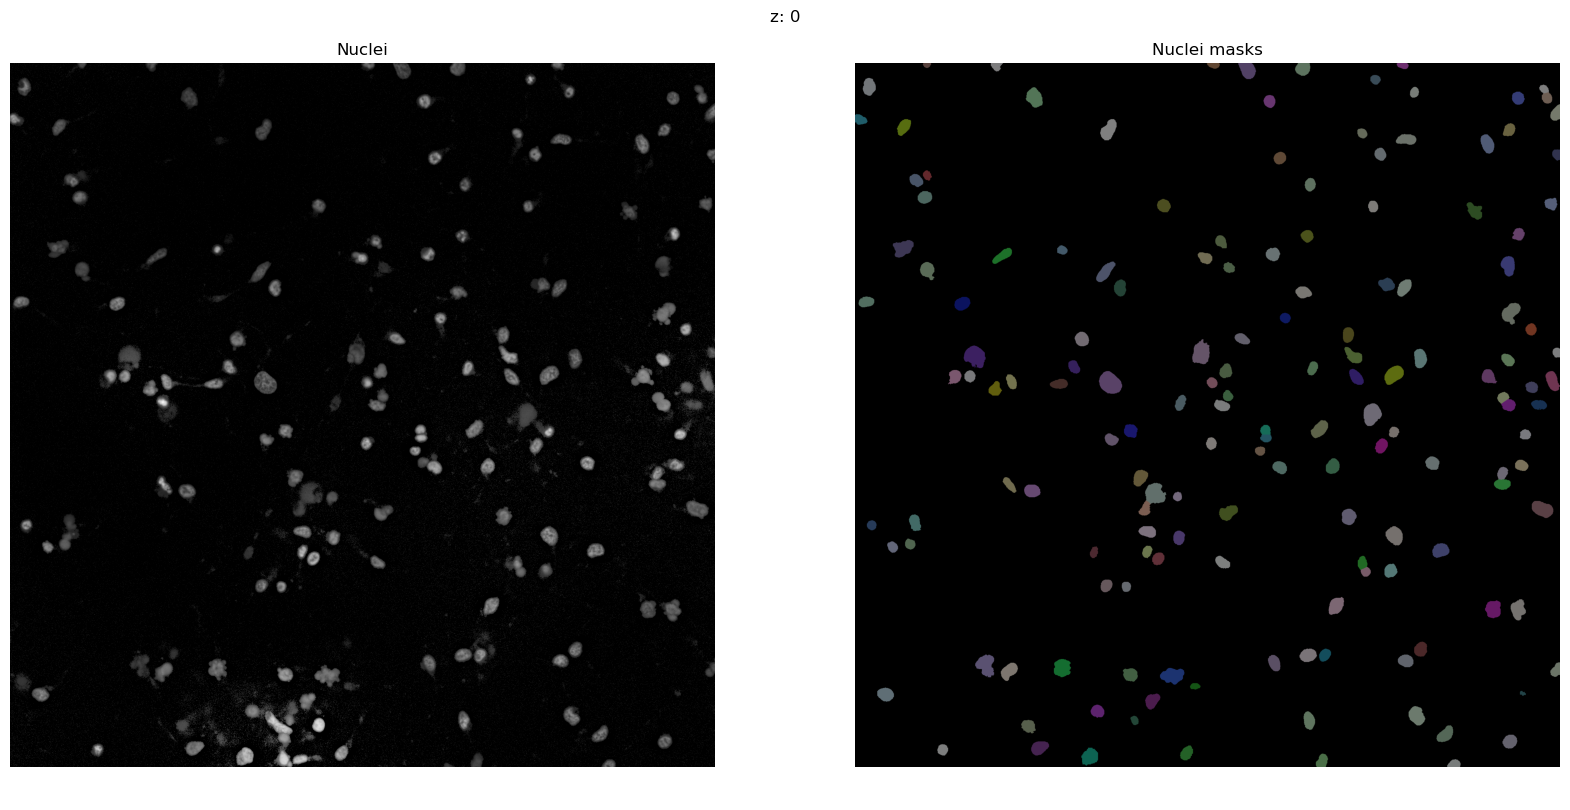

In [9]:
if in_notebook:
    for z in range(len(masks_all)):
        plt.figure(figsize=(20, 10))
        plt.title(f"z: {z}")
        plt.axis("off")
        plt.subplot(1, 2, 1)
        plt.imshow(nuclei[z], cmap="gray")
        plt.title("Nuclei")
        plt.axis("off")

        plt.subplot(122)
        plt.imshow(render_label(masks_all[z]))
        plt.title("Nuclei masks")
        plt.axis("off")
        plt.show()

In [10]:
# set up memory profiler for GPU
device = torch.device("cuda:0")
free_after, total_after = torch.cuda.mem_get_info(device)
amount_used = ((total_after - free_after)) / 1024**2
print(f"Used: {amount_used} MB or {amount_used / 1024} GB of GPU RAM")

Used: 12229.125 MB or 11.9425048828125 GB of GPU RAM
